# Unsupervised classification of ozone profiles from UKESM1

In this notebook, we use Gaussian mixture modelling as implimented in the scikit-learn python package to classify ozone profiles in the UKESM1 model. We train the model using annual mean profiles from:

1) The historical simulation from 2004-2014

2) SSP126 from 2090-2100

3) SSP585 from 2090-2100

By training the GMM using a combined dataset with profiles from (1)-(3) we ensure that the GMM captures a wide variety of profile types across the forcing scenarios. We then label the profiles separately and examine how the class properties change over time and with forcing scenario. 

### Import modules

In [1]:
#import scikit-learn
from sklearn import mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
#from sklearn.model_selection import train_test_split
# import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib as mpl
# import pandas, numpy, etc.
import pandas as pd
import numpy as np
import os.path
import random
import pickle
import xarray
import json
# for label map
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# number of components
n_components_selected = 8
# save the figure output?
save_figs = True

### Import and preprocess combined data
Annual mean profile data has been processed and collected using Pangeo. here we append the data from the historical run, SSP126, and SSP585 into a single Pandas dataframe for training purposes. Again, we aim to use a single training dataset. 

In [3]:
#import data in mPa concentration
data1 = pd.read_csv('data_in/Historical (mPahpa).csv')
data2 = pd.read_csv('data_in/ssp126.csv')
data3 = pd.read_csv('data_in/ssp585.csv')
data  = data1.append([data2,data3], ignore_index=True)
data

x       y  year      1000       925       850       700  \
0         0.9375 -89.375  2004       NaN       NaN  0.000000  0.033317   
1         2.8125 -89.375  2004       NaN       NaN  0.000000  0.032572   
2         4.6875 -89.375  2004       NaN       NaN  0.000000  0.032322   
3         6.5625 -89.375  2004       NaN       NaN  0.000000  0.031188   
4         8.4375 -89.375  2004       NaN       NaN  0.000000  0.029072   
...          ...     ...   ...       ...       ...       ...       ...   
912379  351.5625  89.375  2100  3.162622  3.190067  3.224525  3.233835   
912380  353.4375  89.375  2100  3.163913  3.190171  3.224290  3.233778   
912381  355.3125  89.375  2100  3.164482  3.190093  3.224035  3.233881   
912382  357.1875  89.375  2100  3.164103  3.189843  3.223689  3.233761   
912383  359.0625  89.375  2100  3.163964  3.189818  3.223235  3.233525   

             600       500       400  ...       200        150        100  \
0       1.425523  1.306173  1.216804  ...  2.988156   4.724700   6.954747   
1       1.425464  1.306115  1.216855  ...  2.988349   4.724773   6.953703   
2       1.425406  1.306058  1.216921  ...  2.988592   4.724698   6.952686   
3       1.425310  1.305990  1.216970  ...  2.988632   4.724542   6.952015   
4       1.425186  1.305919  1.217012  ...  2.988753   4.724380   6.951464   
...          ...       ...       ...  ...       ...        ...        ...   
912379  3.095912  2.885357  2.648233  ...  8.307146  14.777760  18.562505   
912380  3.095650  2.885561  2.648152  ...  8.305343  14.775007  18.560309   
912381  3.095532  2.885838  2.647984  ...  8.303542  14.772373  18.558230   
912382  3.095465  2.886141  2.647722  ...  8.301743  14.769791  18.556179   
912383  3.095180  2.886392  2.647422  ...  8.299916  14.767187  18.554198   

               70         50         30         20        10         5  \
0       10.610146  11.517317   8.749299   6.956750  3.771995  1.865903   
1       10.609796  11.518040   8.750002   6.957058  3.772319  1.866040   
2       10.609513  11.518767   8.750786   6.957266  3.772657  1.866182   
3       10.609066  11.519486   8.751647   6.957454  3.773013  1.866327   
4       10.608552  11.520252   8.752571   6.957660  3.773389  1.866487   
...           ...        ...        ...        ...       ...       ...   
912379  20.655736  19.384623  14.418304  10.612991  6.276429  3.544890   
912380  20.654239  19.383636  14.417912  10.612202  6.275832  3.544687   
912381  20.652801  19.382613  14.417550  10.611347  6.275282  3.544500   
912382  20.651355  19.381626  14.417221  10.610457  6.274782  3.544315   
912383  20.649885  19.380723  14.416918  10.609642  6.274306  3.544139   

               1  
0       0.195149  
1       0.195160  
2       0.195171  
3       0.195183  
4       0.195196  
...          ...  
912379  0.307701  
912380  0.307683  
912381  0.307667  
912382  0.307651  
912383  0.307633  

[912384 rows x 22 columns]

In [4]:
# keep 'data' as the unmodified original
data_cleaned = data

# drop rows (profiles) with NaNs
data_cleaned = data_cleaned.dropna()
data_cleaned = data_cleaned.reset_index(drop=True)

# extract pressure values from the column headers
p = data_cleaned.columns[3:].values

# let's work with the cleaned up dataset
df = data_cleaned

# get the latitudes, and longitudes for each profile
lon = df.iloc[:,0].values
lat = df.iloc[:,1].values
year = df.iloc[:,2].values

# get the array that will be used to fit the GMM object
X = df.iloc[:,3:].values

# count the number of profiles in the full, combined dataset
nProfiles = X[:,1].size
nProfiles

678810

### Scale data, apply PCA transformation for dimension reduction

We do not have to use information from every pressure level to classify the profiles. We can use a reduced-dimension version of the dataset that preserves most of the variance (over 99.6% using 10 components). This dimensionality reduction step improves the computational efficiency of the fitting process. 

In [5]:
# scale by variable
Xscaled = preprocessing.scale(X)

# create PCA object
pca = PCA(n_components=10)

# fit PCA model
pca.fit(Xscaled)

# transform input data into PCA representation
Xpca = pca.transform(Xscaled)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9968509541370176

### GMM and BIC

Here we either (1) load the GMM if it exists or (2) create a plot of BIC to guide our choice of the number of components. The BIC score is a statistical guide that can help make decisions about the complexity of the model; it should not be used as an automatic way to select the number of profiles. 

In [6]:
# if file exists, then load it. Otherwise, calculate best GMM model
if os.path.isfile('n' + str(n_components_selected) + 'best_gmm_means.npy'):

    # set gmm_loaded flag to true
    gmm_loaded = True
    print('Found a GMM file, loading pre-fit GMM')
    
    # reload
#    gmm_name = 'best_gmm'
#    npzfile = np.load(gmm_name + '_all3.npz')
#    weights = npzfile['weights']       # weights 
#    means = npzfile['means']         # means 
#    covar = npzfile['covariances']   # covariances
#    best_gmm = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
#    best_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
#    best_gmm.means_ = means
#    best_gmm.covariances_ = covar
    
    # reload
    gmm_name = 'n' + str(n_components_selected) + 'best_gmm'
    means = np.load(gmm_name + '_means.npy')
    covar = np.load(gmm_name + '_covariances.npy')
    loaded_gmm = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
    loaded_gmm.means_ = means
    loaded_gmm.covariances_ = covar
    best_gmm = loaded_gmm

else:
    
    # set gmm_loaded flag to true
    gmm_loaded = False
    
    # select parameters
    max_N = 20     # the maximum number of classes to try 
    max_bic_iter = 20  # the maximum number of iterations for BIC

    # for the BIC step, try using a subset of the profiles
    # you can change this 1000 value for different subsets
    #Xpca_for_BIC = Xpca[::1000]

    # initialise, declare variables
    lowest_bic = np.infty
    bic_scores = np.zeros((2,max_bic_iter))

    # loop through the maximum number of classes, estimate BIC
    n_components_range = range(2, max_N)
    bic_iter_range = range(0,max_bic_iter)
    # iterate through all the covariance types (just 'full' for now)
    cv_types = ['full']
    for cv_type in cv_types:
        # iterate over all the possible numbers of components
        for n_components in n_components_range:
            bic_one = []
            # repeat the BIC step for better statistics
            for bic_iter in bic_iter_range:
                # select a new random subset
                rows_id = random.sample(range(0,Xpca.shape[0]-1), 1000)
                Xpca_for_BIC = Xpca[rows_id,:]
                # fit a Gaussian mixture model
                gmm = mixture.GaussianMixture(n_components=n_components,
                                              covariance_type=cv_type,
                                              random_state=42)

                # uncomment for 'rapid' BIC fitting
                gmm.fit(Xpca_for_BIC)
                # uncomment for 'full' BIC fitting
                #gmm.fit(Xpca)

                # append this BIC score to the list
                bic_one.append(gmm.bic(Xpca_for_BIC))
                Xpca_for_BIC = []

            # stack the bic scores into a single 2D structure
            bic_scores = np.vstack((bic_scores, np.asarray(bic_one)))

    # the first two rows are not needed; they were only placeholders
    bic_scores = bic_scores[2:,:]

    # mean values for BIC
    bic_mean = np.mean(bic_scores, axis=1)

    # standard deviation for BIC
    bic_std = np.std(bic_scores, axis=1)

    # examine the mean bic values
    #bic_mean

    # plot the BIC scores
    plt.figure(figsize=(20, 8))
    plt.style.use('seaborn-darkgrid')
    spl = plt.subplot(2, 1, 1)
    plt.plot(n_components_range, bic_mean-bic_std, '--')  
    plt.plot(n_components_range, bic_mean, '-')  
    plt.plot(n_components_range, bic_mean+bic_std, '--')  
    plt.xticks(n_components_range)
    #plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model', fontsize=18)
    spl.set_xlabel('Number of components',fontsize=18)
    spl.set_ylabel('BIC score',fontsize=18)
    #plt.show()

    # save figure
    #plt.savefig("BIC score per model (UKESM)",
    #           bbox_inches="tight",transparent=False)

The BIC score drops rapidly with the addition of classes up until n=6, after which point the BIC reductions become increasingly small. We can justify using a range of n values depending on how complex we want our statistical model to be. Simpler models will be easier to interpret but will miss some features of the dataset; models with a larger number of classes will be harder to interpret but will capture more sub-populations in the dataset. 

The code below is adpated from this repository for the loading and saving of GMM models:

https://gist.github.com/Kukanani/619a27d8a8cc1b245ef2d30f671a4a37

In [7]:
# if the file exists, it should already be loaded. Print it out. 
if gmm_loaded==True:
    
    # print out best_gmm
    print('GMM has been pre-fit and it already loaded')
    best_gmm
    
else:
    
    # fit the "best" GMM model using the full Xpca dataset
    best_gmm = mixture.GaussianMixture(n_components=n_components_selected, 
                                       covariance_type='full', 
                                       random_state=42)
    best_gmm.fit(Xpca)
    # save to file
    gmm_name = 'n' + str(n_components_selected) + 'best_gmm' 
    np.save(gmm_name + '_weights', best_gmm.weights_, allow_pickle=False)
    np.save(gmm_name + '_means', best_gmm.means_, allow_pickle=False)
    np.save(gmm_name + '_covariances', best_gmm.covariances_, allow_pickle=False)


## Calculate the profile types for the entire dataset

We should identify the possible "profile types" here, using profiles from the entire combined dataset.

In [8]:
# check to make sure that n_comp is as expected
n_comp = best_gmm.n_components

# select colormap
colormap = plt.get_cmap('tab10', n_comp)

# assign class labels ("predict" the class using the selected GMM)
labels = best_gmm.predict(Xpca)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = best_gmm.predict_proba(Xpca)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df.insert(3,'label',labels,True)
df.insert(4,'max posterior prob',max_posterior_probs,True) 

# print out best_gmm parameters
best_gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [9]:
# group by label
grouped_unsorted = df.groupby('label')

# calculate mean of all profiles in each class
df_means = grouped_unsorted.mean()

oz_means = df_means['y'].values

old2new = np.argsort(oz_means)

# create dictionary object for sorting
di = dict(zip(old2new,range(0,n_comp)))

# add new column to dataframe - sorted label
df.insert(4,'label_sorted',df['label'].map(di))

# group profiles according to label
grouped = df.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means = grouped.mean()

# calculate stdevs of all profiles in each class
dfg_stds = grouped.std()

# number or profiles in each class
nprofs = grouped['x'].count().values

# count number of profiles at each location
gbl = df.groupby('x')
Al1=gbl.count()['label_sorted']
nprofs_ = Al1[df['x'].values].values

# number of components
n_comp = best_gmm.n_components

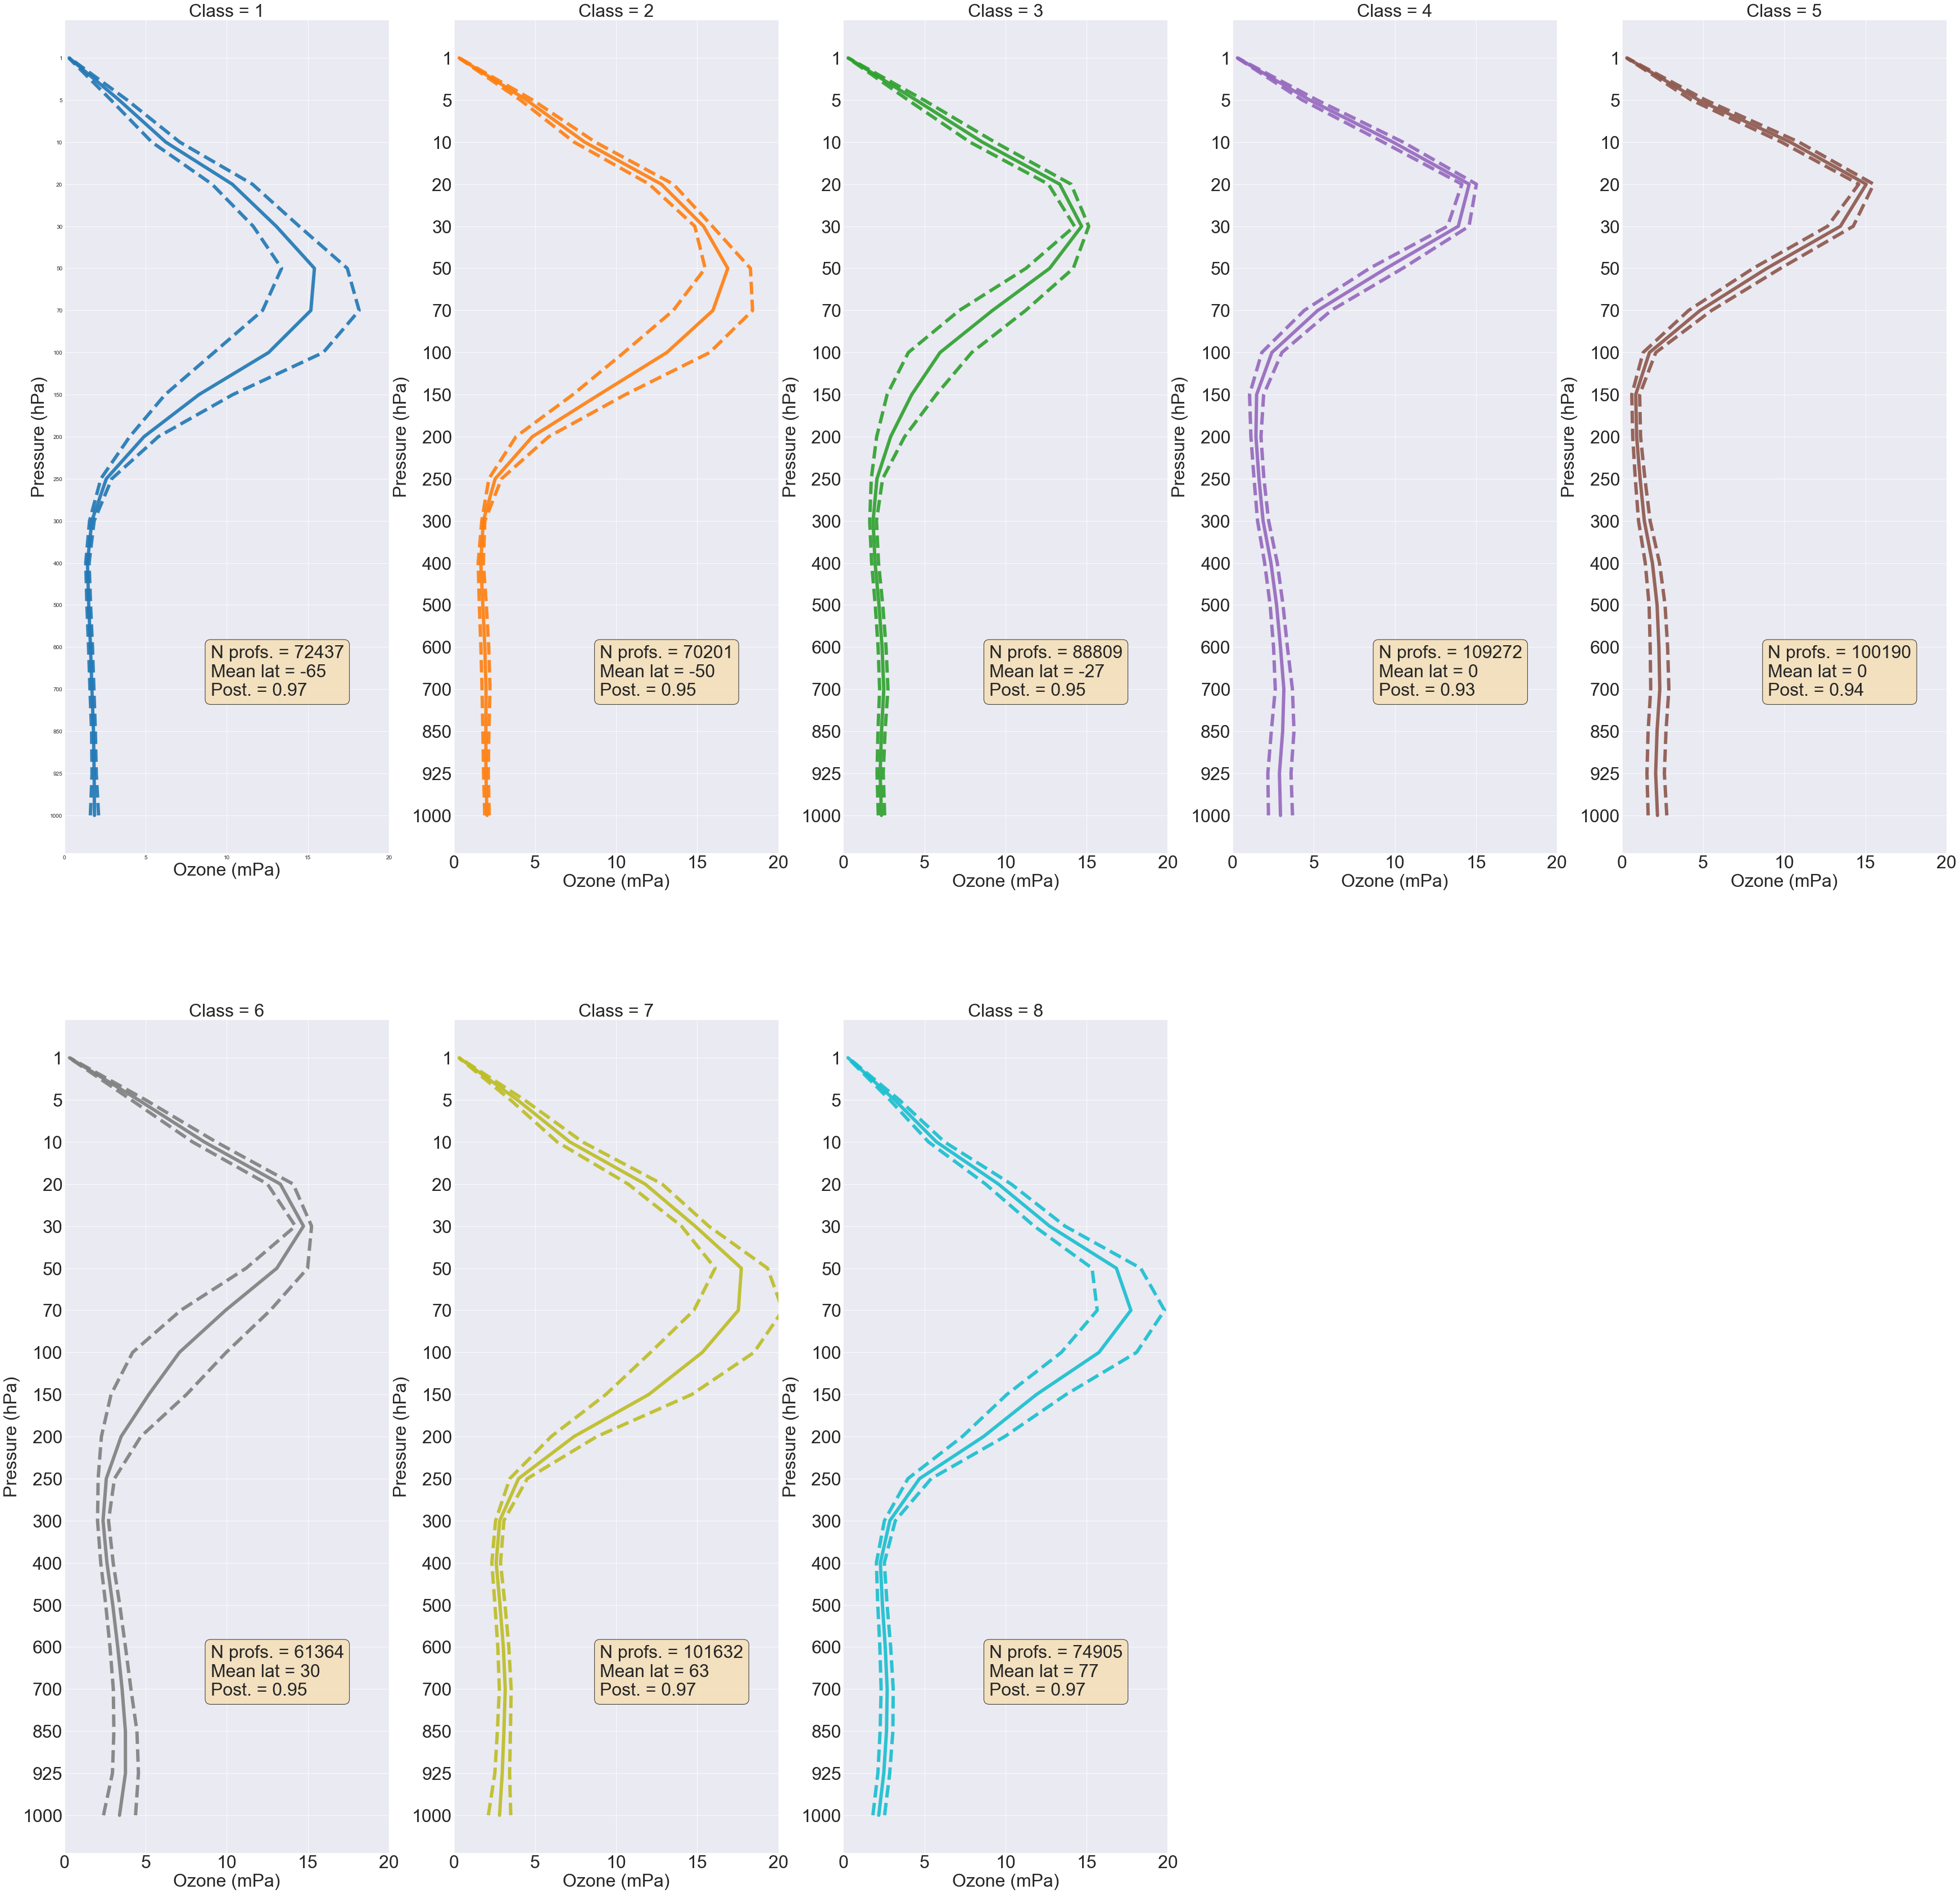

In [10]:
#classes for historical data set
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
    # extract means
    mean_lon = dfg_means.iloc[nrow,0]
    mean_lat = dfg_means.iloc[nrow,1]
    mean_maxpp = dfg_means.iloc[nrow,4]
    mean_T = dfg_means.iloc[nrow,5:].values
    
    # extract stdevs
    std_lon = dfg_stds.iloc[nrow,0]
    std_lat = dfg_stds.iloc[nrow,1]
    std_maxpp = dfg_stds.iloc[nrow,4]
    std_T = dfg_stds.iloc[nrow,5:].values
    
    # select subplot
    plt.subplot(np.ceil(n_comp/5),5,num)
    plt.plot(mean_T, p, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T+std_T, p, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T-std_T, p, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 20])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs[nrow], ),
        #r'Mean lon = %i' % (mean_lon, ),
        r'Mean lat = %i' % (mean_lat, ),
        r'Post. = %.2f' % (mean_maxpp, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   
   #plt.show()

# later, uncomment these to save the figures
if save_figs==True:
    plt.savefig("profile_types",bbox_inches="tight",transparent=False)

## Label the historical dataset separately

We want to create label maps for the three component datasets separately. That will allow us to calculate how the properties have changed over time and with SSP.

In [11]:
# keep 'data' as the unmodified historical original dataset
data_cleaned1 = data1

# drop rows with NaNs
data_cleaned1 = data_cleaned1.dropna()
data_cleaned1 = data_cleaned1.reset_index(drop=True)

#pressure values from the column headers
p1 = data_cleaned1.columns[3:].values


In [12]:
# let's work with the cleaned up historical datset dataset
df1 = data_cleaned1

# get the latitudes, and longitudes for each profile
lon = df1.iloc[:,0].values
lat = df1.iloc[:,1].values
year = df1.iloc[:,2].values

# get the array that will be used to fit the GMM object
X1 = df1.iloc[:,3:].values

# number of profiles for historical dataset
nProfiles1 = X1[:,1].size

# scale by variable 
Xscaled1 = preprocessing.scale(X1)


In [13]:
# create PCA object
#pca = PCA(n_components=10)

# fit PCA model
#pca.fit(Xscaled1)

# transform input data into PCA representation
Xpca1 = pca.transform(Xscaled1)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_


0.9968509541370176

In [14]:
#best_gmm.fit(Xpca1)

# check to make sure that n_comp is as expected
n_comp1 = best_gmm.n_components

# select colormap
#colormap = plt.get_cmap('rainbow', n_comp1)

# assign class labels ("predict" the class using the selected GMM)
labels1 = best_gmm.predict(Xpca1)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs1 = best_gmm.predict_proba(Xpca1)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs1 = np.max(posterior_probs1,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df1.insert(3,'label',labels1,True)
df1.insert(4,'max posterior prob',max_posterior_probs1,True) 

In [15]:
# group by label
grouped_unsorted1 = df1.groupby('label')

# calculate mean of all profiles in each class
df_means1 = grouped_unsorted1.mean()

oz_means1 = df_means1['y'].values

old2new1 = np.argsort(oz_means1)

# create dictionary object for sorting
di1 = dict(zip(old2new1,range(0,n_comp1)))

# add new column to dataframe - sorted label
df1.insert(4,'label_sorted',df1['label'].map(di1))

In [16]:
# avearge at each lat-lon point
#df1.groupby(['x','y']).mean().drop(columns='year')

In [17]:
# group profiles according to label
grouped1 = df1.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means1 = grouped1.mean()

# calculate stdevs of all profiles in each class
dfg_stds1 = grouped1.std()

# number or profiles in each class
nprofs1 = grouped1['x'].count().values

# count number of profiles at each location
gbl1 = df1.groupby('x')
Al1=gbl1.count()['label_sorted']
nprofs1_ = Al1[df1['x'].values].values

# number of components
n_comp = best_gmm.n_components

#### Plot classes for historical dataset

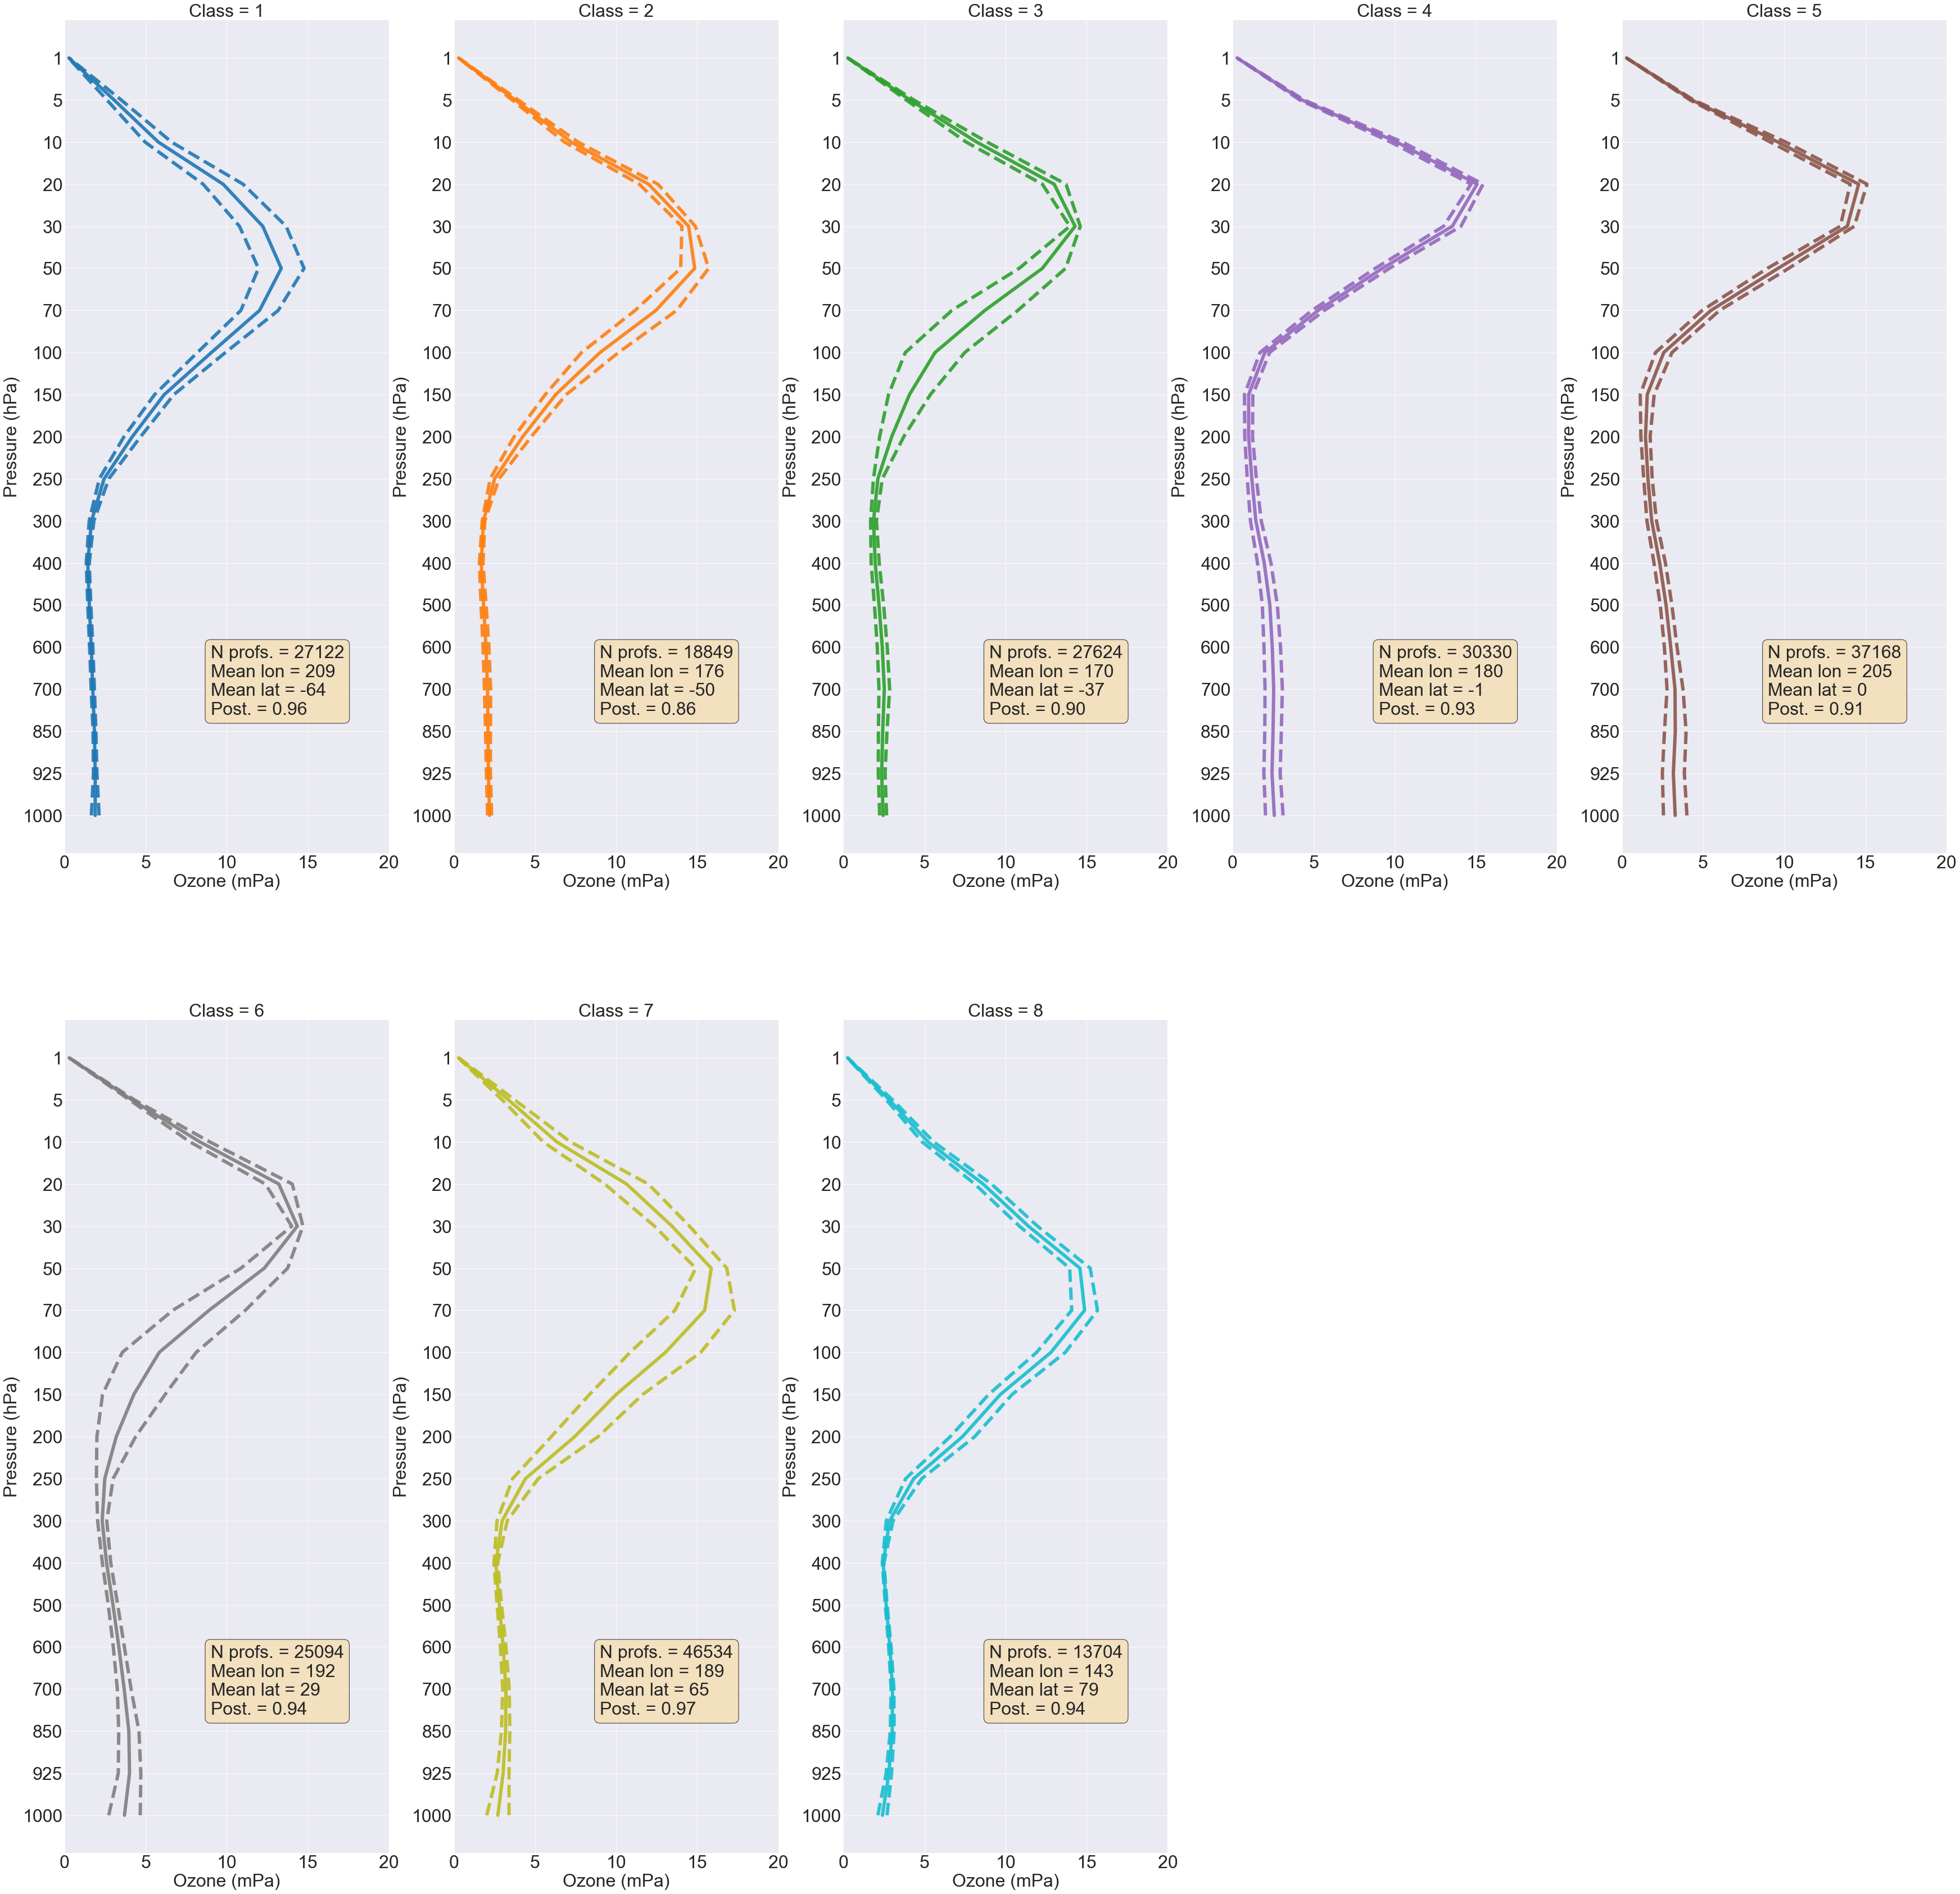

In [18]:
#classes for historical data set
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# iterate over groups
num = 0
for nrow in range(0,n_comp1):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon1 = dfg_means1.iloc[nrow,0]
    mean_lat1 = dfg_means1.iloc[nrow,1]
    mean_maxpp1 = dfg_means1.iloc[nrow,4]
    mean_T1 = dfg_means1.iloc[nrow,5:].values
    
    # extract stdevs
    std_lon1 = dfg_stds1.iloc[nrow,0]
    std_lat1 = dfg_stds1.iloc[nrow,1]
    std_maxpp1 = dfg_stds1.iloc[nrow,4]
    std_T1 = dfg_stds1.iloc[nrow,5:].values
    
    # select subplot
    plt.subplot(np.ceil(n_comp/5),5,num)
    plt.plot(mean_T1, p1, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T1+std_T1, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T1-std_T1, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 20])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs1[nrow], ),
        r'Mean lon = %i' % (mean_lon1, ),
        r'Mean lat = %i' % (mean_lat1, ),
        r'Post. = %.2f' % (mean_maxpp1, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   
   #plt.show()

# later, uncomment these to save the figures
#plt.savefig("profiles_by_class(UKESM (Historical))",
#            bbox_inches="tight",transparent=False)

#### Plot label map for historical dataset

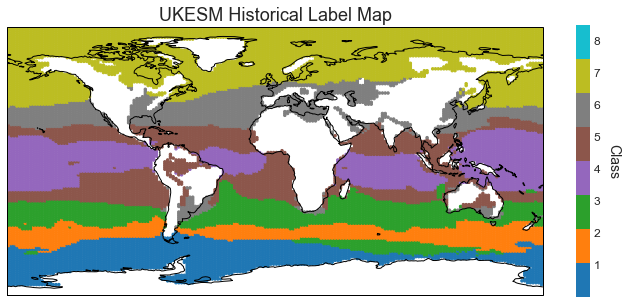

In [19]:
# select a year
df1plot=df1.loc[df1['year'] == 2014]

#colormap with Historical data
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()

cblabels = np.arange(1, int(n_comp1)+1, 1)
cbloc = cblabels

# select sorted labels for plotting, add 1 due ot python's zero index convention
cplot = df1plot['label_sorted'].values + 1

# scatter plot of values (would this be better as a contour plot?)
CS1 = plt.scatter(df1plot['x'].values, df1plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,s=6.0,
                 vmin=0.0, vmax=n_comp+0.5,
                 transform=ccrs.Geodetic(),
                 )

# colorbar
#colorbar = plt.colorbar(CS1, shrink=0.5, spacing='uniform', ticks=cblabels-0.5, boundaries=cblabels)
#colorbar.ax.tick_params(labelsize='large')
#colorbar.set_ticks(cbloc)
#colorbar.set_ticklabels(cblabels)
#colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=20)

colorbar = plt.colorbar(CS1, shrink=0.5)
cblabels = np.arange(1, int(n_comp1)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.ax.tick_params(labelsize='large')
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)

plt.title('UKESM Historical Label Map', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
if save_figs==True:
    plt.savefig("labels_historical",bbox_inches="tight",transparent=False)

In [20]:
x = df1['x'].values
y = df1['y'].values

#### Calculate non-dimensional area occupied by each class

In [21]:
df1['cos_lat'] = np.cos(np.radians(df1['y']))
df1.groupby('label_sorted').sum()['cos_lat']

label_sorted
0    11533.058428
1    12054.156005
2    21824.817268
3    29911.996528
4    35271.456912
5    20297.904289
6    18647.880992
7     2460.308356
Name: cos_lat, dtype: float64

## Label and plot the SSP126 data

In [22]:
# keep 'data' as the unmodified original dataset
data_cleaned2 = data2

# drop rows with NaNs
data_cleaned2 = data_cleaned2.dropna()
data_cleaned2 = data_cleaned2.reset_index(drop=True)

# for simple plotting, extract an array of values 
A2 = data_cleaned2.drop(columns=['x','y']).values

In [23]:
# let's work with the cleaned up dataset
df2 = data_cleaned2

# get the latitudes, and longitudes for each profile
lon = df2.iloc[:,0].values
lat = df2.iloc[:,1].values
year = df2.iloc[:,2].values

# get the array that will be used to fit the GMM object
X2 = df2.iloc[:,3:].values

# number of profiles
nProfiles2 = X2[:,1].size
nProfiles2
# scale by variable
Xscaled2 = preprocessing.scale(X2)


In [24]:
# create PCA object
#pca = PCA(n_components=10)

# fit PCA model
#pca.fit(Xscaled2)

# transform input data into PCA representation
Xpca2 = pca.transform(Xscaled2)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9968509541370176

In [25]:
#best_gmm.fit(Xpca2)

# check to make sure that n_comp is as expected
n_comp2 = best_gmm.n_components

# select colormap
#colormap = plt.get_cmap('rainbow', n_comp2)

# assign class labels ("predict" the class using the selected GMM)
labels2 = best_gmm.predict(Xpca2)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs2 = best_gmm.predict_proba(Xpca2)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs2 = np.max(posterior_probs2,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df2.insert(3,'label',labels2,True)
df2.insert(4,'max posterior prob',max_posterior_probs2,True) 

In [26]:
# group by label
grouped_unsorted2 = df2.groupby('label')

# calculate mean of all profiles in each class
df_means2 = grouped_unsorted2.mean()

# extrat ozone values 
oz_means2 = df_means2['y'].values

old2new2 = np.argsort(oz_means2)

# create dictionary object for sorting
di2 = dict(zip(old2new2,range(0,n_comp2)))

# add new column to dataframe - sorted label
df2.insert(3,'label_sorted',df2['label'].map(di2))

# group profiles according to label
grouped2 = df2.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means2 = grouped2.mean()

# calculate stdevs of all profiles in each class
dfg_stds2 = grouped2.std()

# number or profiles in each class
nprofs2 = grouped2['x'].count().values


In [27]:
# count number of profiles at each location
gbl2 = df2.groupby('x')
Al2 =gbl2.count()['label_sorted']
nprofs2_ = Al2[df2['x'].values].values

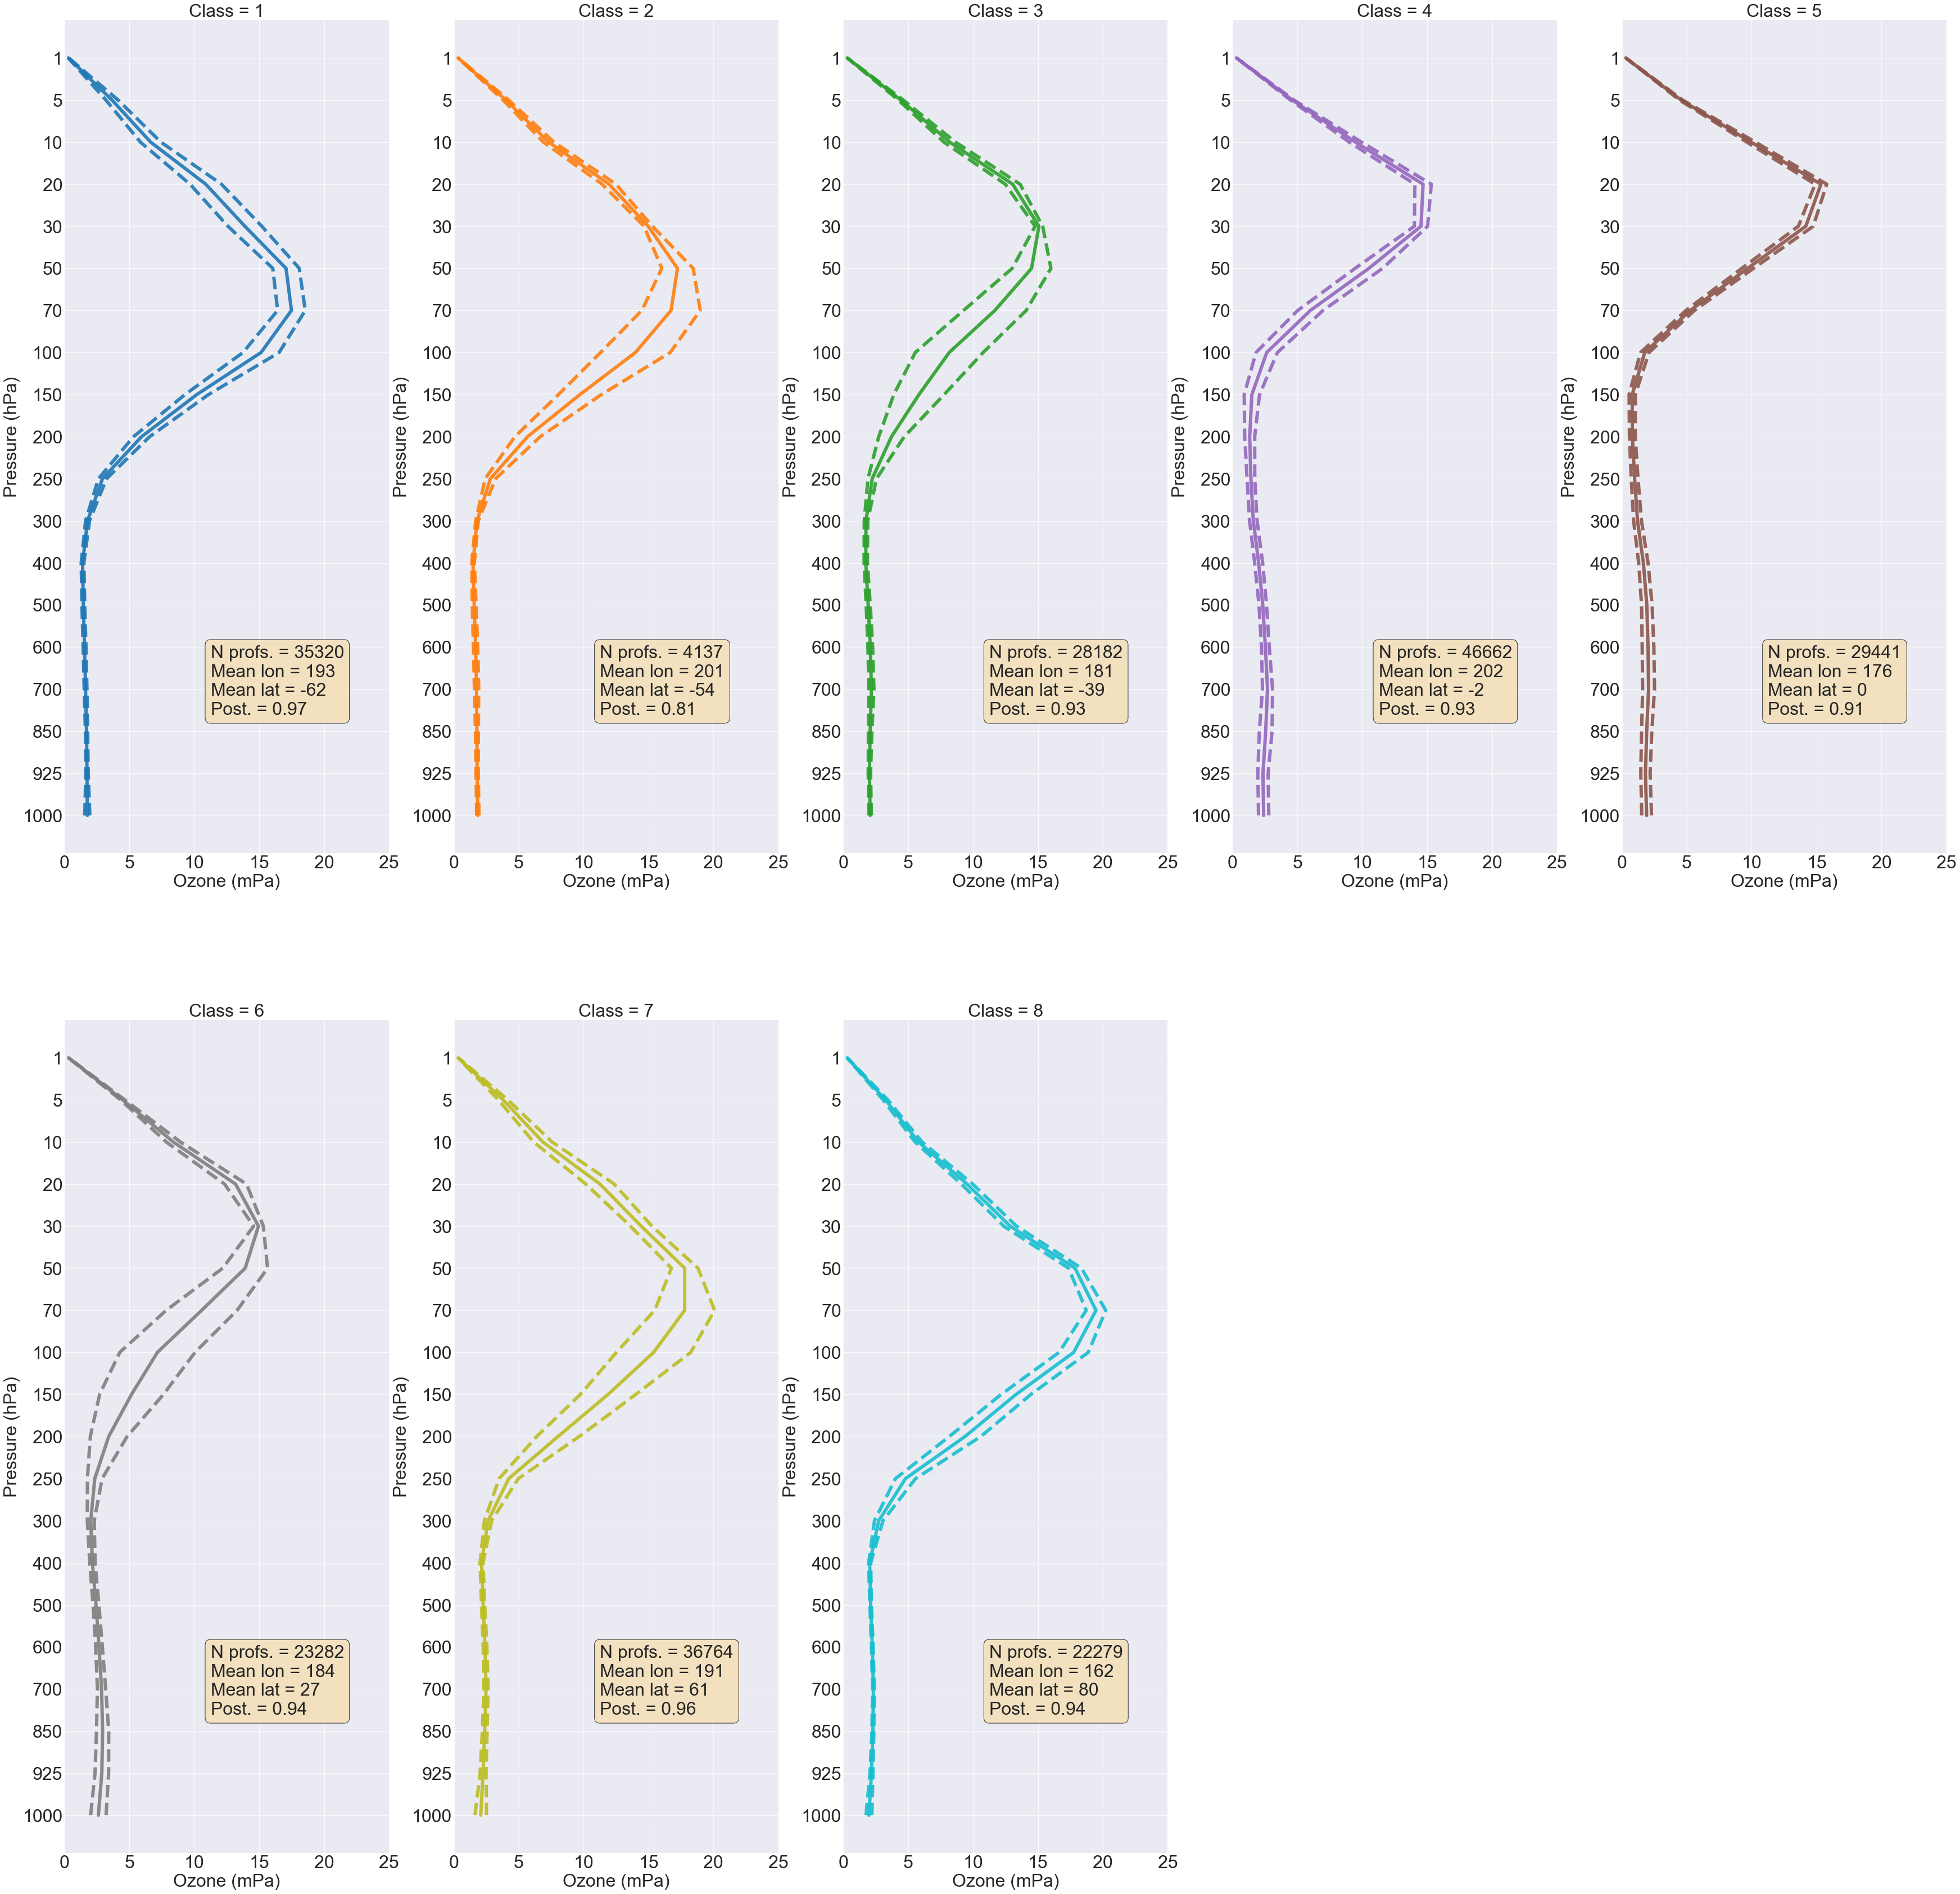

In [28]:
#classes for strong carbon emission reduction (SSP126)
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# iterate over groups
num = 0
for nrow in range(0,n_comp2):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon2 = dfg_means2.iloc[nrow,0]
    mean_lat2 = dfg_means2.iloc[nrow,1]
    mean_maxpp2 = dfg_means2.iloc[nrow,4]
    mean_T2 = dfg_means2.iloc[nrow,5:].values
    
    # extract stdevs
    std_lon2 = dfg_stds2.iloc[nrow,0]
    std_lat2 = dfg_stds2.iloc[nrow,1]
    std_maxpp2 = dfg_stds2.iloc[nrow,4]
    std_T2 = dfg_stds2.iloc[nrow,5:].values
    
    # select subplot
    plt.subplot(np.ceil(n_comp/5),5,num)
    plt.plot(mean_T2, p1, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T2+std_T2, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T2-std_T2, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 25])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs2[nrow], ),
        r'Mean lon = %i' % (mean_lon2, ),
        r'Mean lat = %i' % (mean_lat2, ),
        r'Post. = %.2f' % (mean_maxpp2, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   #plt.show()

# later, uncomment these to save the figures
#plt.savefig("profiles_by_class(ssp126)",
           #bbox_inches="tight",transparent=False)

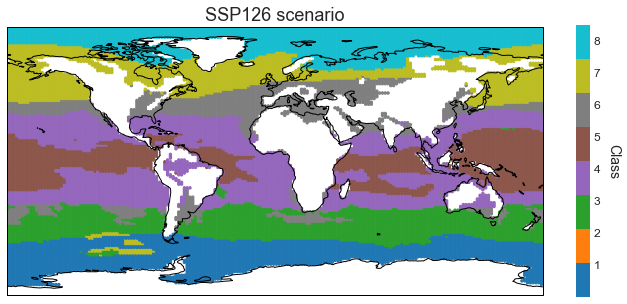

In [29]:
# select a year
df2plot=df2.loc[df2['year'] == 2100]

#colormap with carbon emission reduction (SSP126)
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()

cplot = df2plot['label_sorted'].values + 1

CS2 = plt.scatter(df2plot['x'].values, df2plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,s=6.0,
                 vmin=0.0, vmax=n_comp+0.5,
                 transform=ccrs.Geodetic(),
                 )

colorbar = plt.colorbar(CS2, shrink=0.5)
cblabels = np.arange(1, int(n_comp2)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)
colorbar.ax.tick_params(labelsize='large')
plt.title('SSP126 scenario', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
if save_figs==True:
    plt.savefig("labels_ssp126",bbox_inches="tight",transparent=False)

#### Sum non-dimensional area associated with each class

In [30]:
df2['cos_lat'] = np.cos(np.radians(df2['y']))
df2.groupby('label_sorted').sum()['cos_lat']

label_sorted
0    16371.705623
1     2403.365530
2    21514.699666
3    43828.432885
4    28969.183142
5    18417.595572
6    16859.063700
7     3596.581435
Name: cos_lat, dtype: float64

## Label and plot the SSP585 data

In [31]:
# keep 'data' as the unmodified original dataset
data_cleaned3 = data3

# drop rows with NaNs
data_cleaned3 = data_cleaned3.dropna()
data_cleaned3 = data_cleaned3.reset_index(drop=True)


In [32]:
# let's work with the cleaned up dataset
df3 = data_cleaned3

# get the latitudes, and longitudes for each profile
lon = df3.iloc[:,0].values
lat = df3.iloc[:,1].values
year = df3.iloc[:,2].values

# get the array that will be used to fit the GMM object
X3 = df3.iloc[:,3:].values

# number of profiles
nProfiles3 = X3[:,1].size
nProfiles3
# scale by variable
Xscaled3 = preprocessing.scale(X3)


In [33]:
# create PCA object
#pca = PCA(n_components=10)

# fit PCA model
#pca.fit(Xscaled3)

# transform input data into PCA representation
Xpca3 = pca.transform(Xscaled3)

# calculated total variance explained
total_variance_explained_ = np.sum(pca.explained_variance_ratio_) 
total_variance_explained_

0.9968509541370176

In [34]:

#best_gmm.fit(Xpca3)

# check to make sure that n_comp is as expected
n_comp3 = best_gmm.n_components

# select colormap
#colormap = plt.get_cmap('rainbow', n_comp3)

# assign class labels ("predict" the class using the selected GMM)
labels3 = best_gmm.predict(Xpca3)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs3 = best_gmm.predict_proba(Xpca3)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs3 = np.max(posterior_probs3,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df3.insert(3,'label',labels3,True)
df3.insert(4,'max posterior prob',max_posterior_probs3,True) 

In [35]:
# group by label
grouped_unsorted3 = df3.groupby('label')

# calculate mean of all profiles in each class
df_means3 = grouped_unsorted3.mean()

oz_means3 = df_means3['y'].values

old2new3 = np.argsort(oz_means3)

# create dictionary object for sorting
di3 = dict(zip(old2new3,range(0,n_comp3)))

# add new column to dataframe - sorted label
df3.insert(3,'label_sorted',df3['label'].map(di3))

# group profiles according to label
grouped3 = df3.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means3 = grouped3.mean()

# calculate stdevs of all profiles in each class
dfg_stds3 = grouped3.std()

# number or profiles in each class
nprofs3 = grouped3['x'].count().values


In [36]:
# count number of profiles at each location
gbl3 = df3.groupby('x')
Al3=gbl3.count()['label_sorted']
nprofs3_ = Al3[df3['x'].values].values

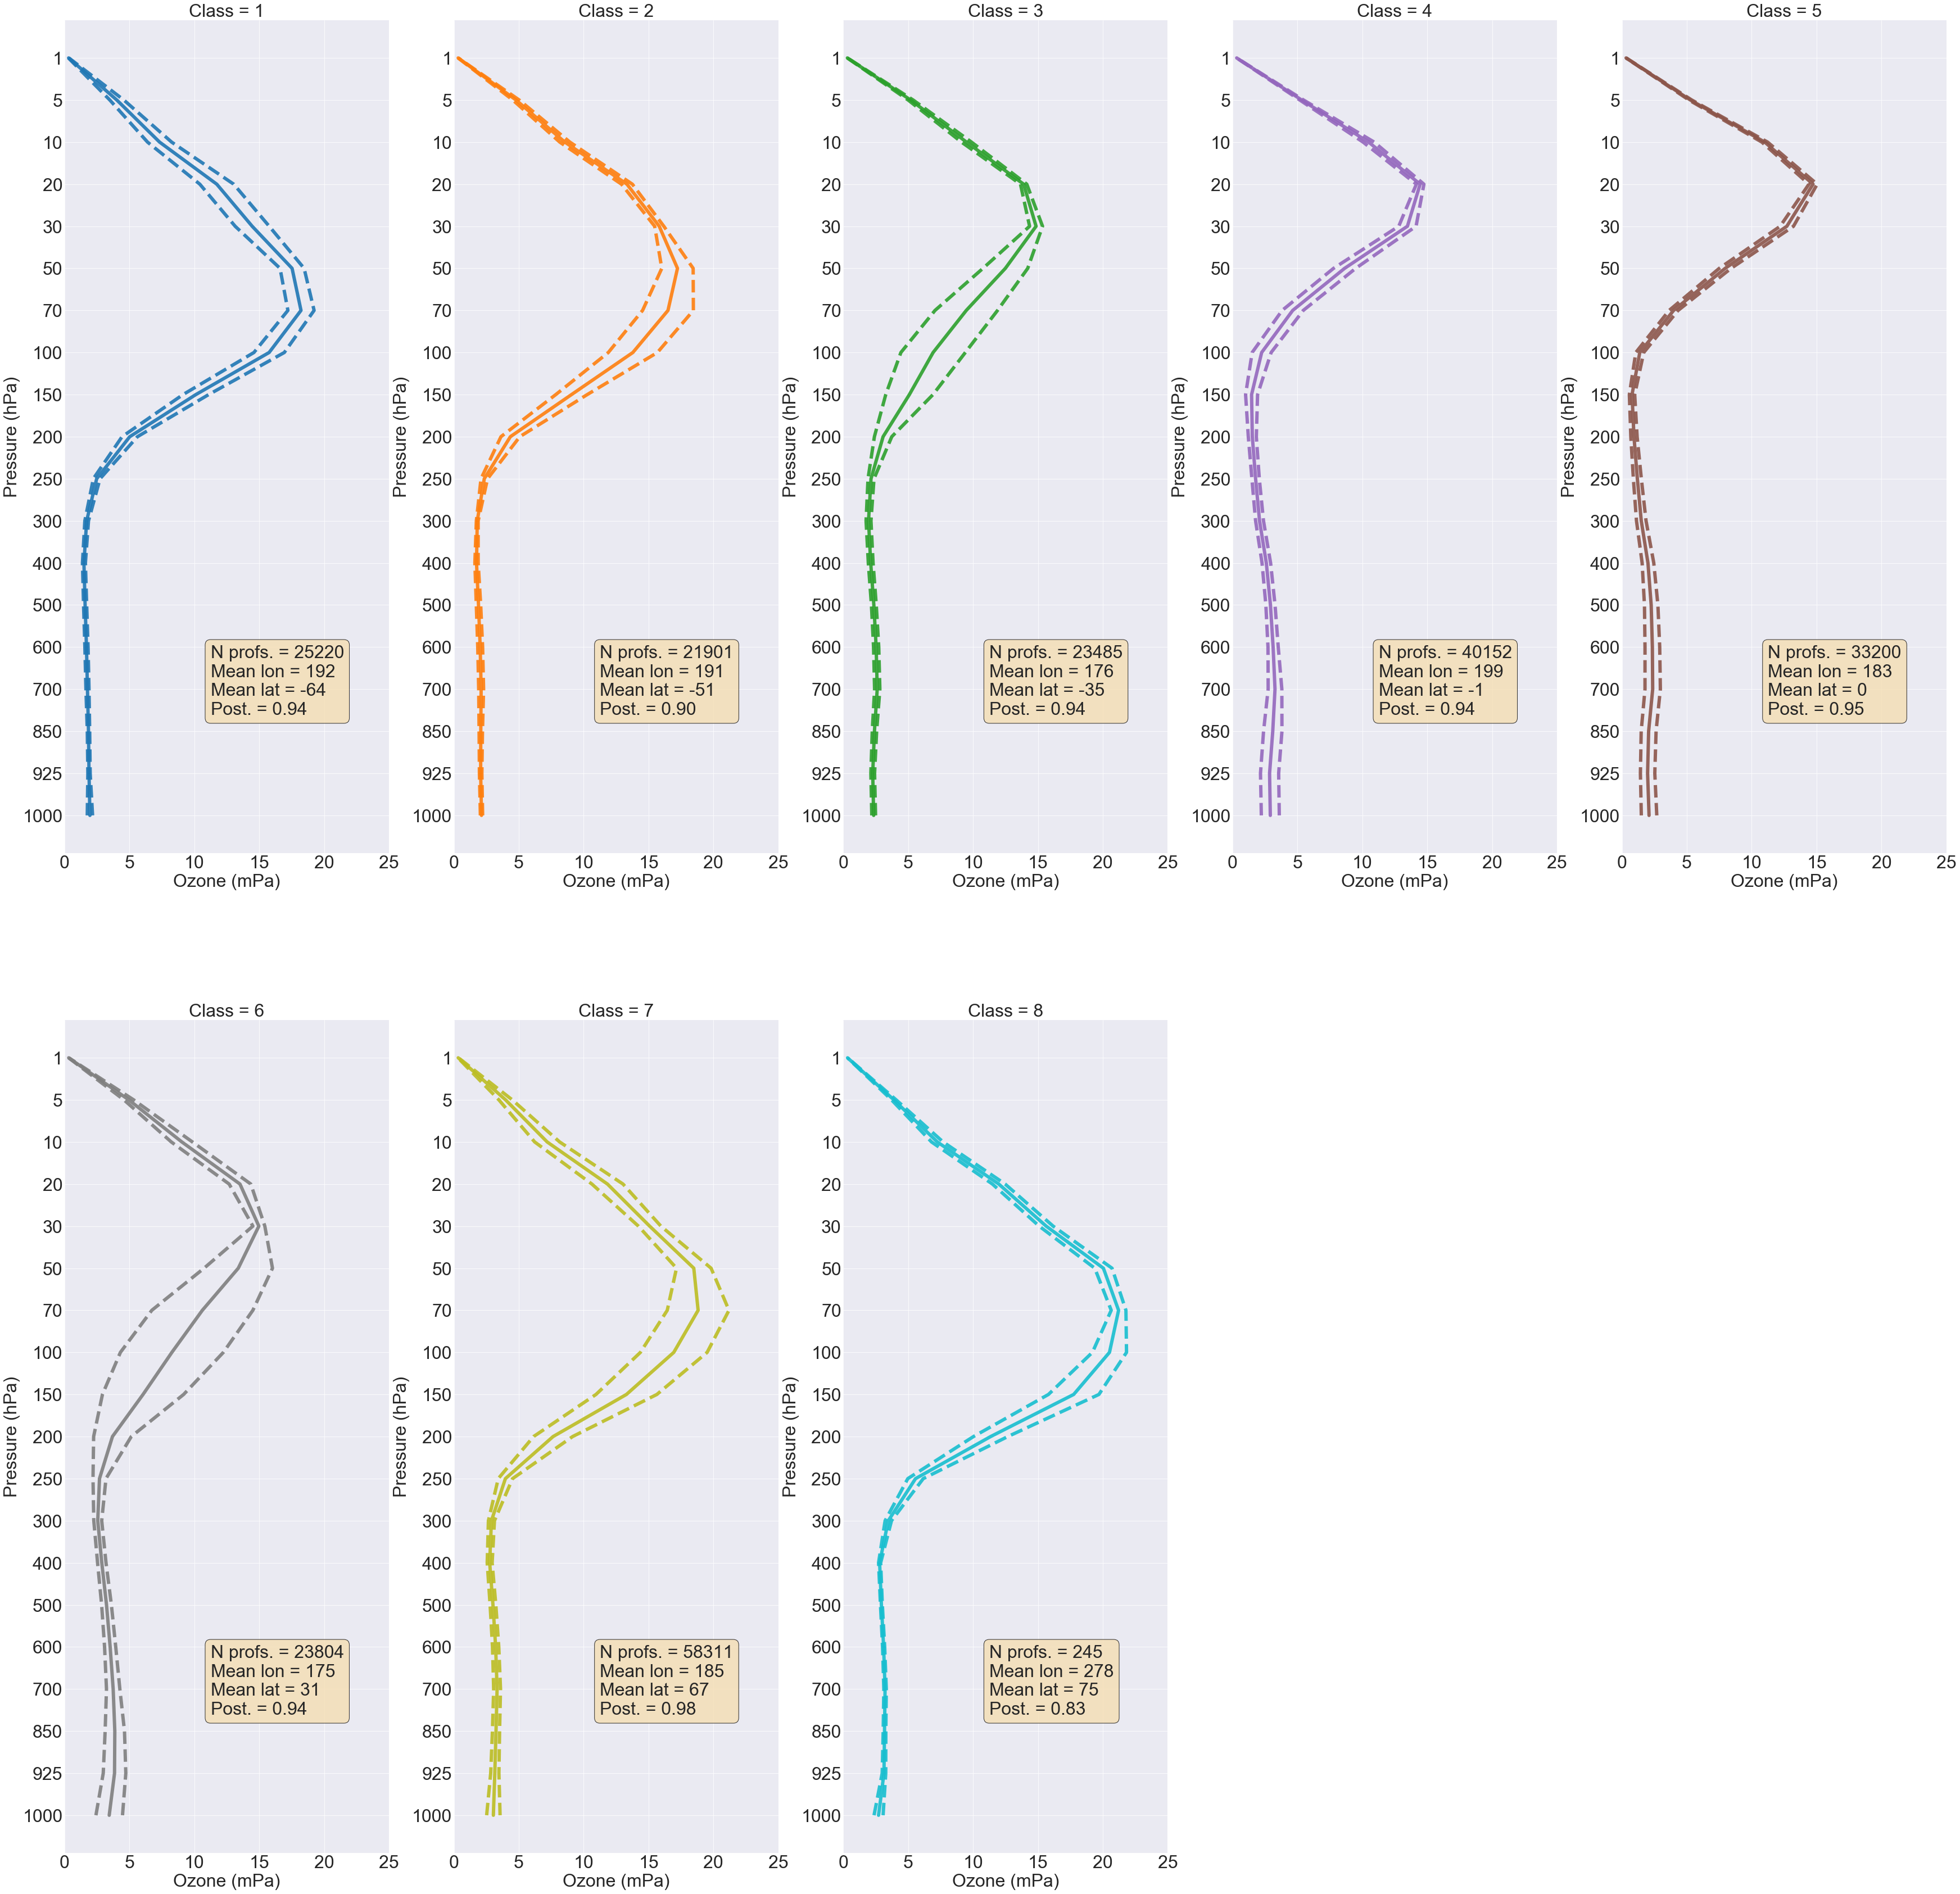

In [37]:
#classes for no carbon emission reduction (SSP585)
cNorm = colors.Normalize(vmin=0, vmax=n_comp)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

# initialize the figure
plt.figure(figsize=(60, 60))
plt.style.use('seaborn-darkgrid')
#palette = cmx.Paired(np.linspace(0,1,n_comp))
 
# iterate over groups
num = 0
for nrow in range(0,n_comp3):
    num += 1
    colorVal = scalarMap.to_rgba(nrow)
     # extract means
    mean_lon3 = dfg_means3.iloc[nrow,0]
    mean_lat3 = dfg_means3.iloc[nrow,1]
    mean_maxpp3 = dfg_means3.iloc[nrow,4]
    mean_T3 = dfg_means3.iloc[nrow,5:].values
    
    # extract stdevs
    std_lon3 = dfg_stds3.iloc[nrow,0]
    std_lat3 = dfg_stds3.iloc[nrow,1]
    std_maxpp3 = dfg_stds3.iloc[nrow,4]
    std_T3 = dfg_stds3.iloc[nrow,5:].values
    
    # select subplot
    plt.subplot(np.ceil(n_comp/5),5,num)
    plt.plot(mean_T3, p1, marker='', linestyle='solid', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T3+std_T3, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    plt.plot(mean_T3-std_T3, p1, marker='', linestyle='dashed', color=colorVal, linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    #plt.ylim([0,950])
    ax = plt.gca()
    #ax.invert_yaxis() 
    plt.xlim([0, 25])
    #ax.grid(True)
    
   #text box
    fs = 32 # font size
    plt.xlabel('Ozone (mPa)', fontsize=fs)
    plt.ylabel('Pressure (hPa)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # this creates the test boxes that display the class statistics
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs3[nrow], ),
        r'Mean lon = %i' % (mean_lon3, ),
        r'Mean lat = %i' % (mean_lat3, ),
        r'Post. = %.2f' % (mean_maxpp3, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)   
   
   #plt.show()

# later, uncomment these to save the figures
#plt.savefig("profiles_by_class_later(ssp585)",
            #bbox_inches="tight",transparent=False)

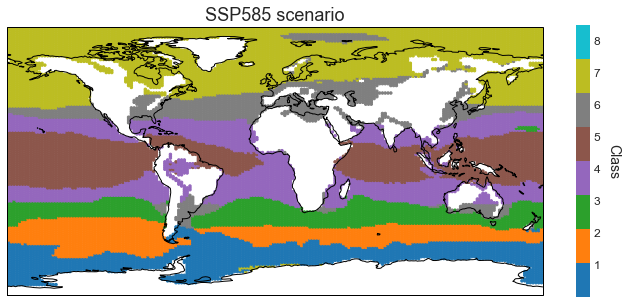

In [38]:
# select year
df3plot=df3.loc[df3['year']==2100]

#colormap with no carbon emission reduction (SSP585)
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()

cplot = df3plot['label_sorted'].values + 1

CS3 = plt.scatter(df3plot['x'].values, df3plot['y'].values, c=cplot,
                 marker='o',cmap= colormap,s=6.0,
                 vmin=0.0, vmax=n_comp+0.5,
                 transform=ccrs.Geodetic(),
                 )

colorbar = plt.colorbar(CS3, shrink=0.5)
cblabels = np.arange(1, int(n_comp3)+1, 1)
cbloc = cblabels
colorbar.set_ticks(cbloc)
colorbar.set_ticklabels(cblabels)
colorbar.set_label('Class', rotation=270, labelpad=20,fontsize=14)
colorbar.ax.tick_params(labelsize='large')
plt.title('SSP585 scenario', fontsize=18) 
#plt.show()

# eventually, uncomment this in order to save the images
if save_figs==True:
    plt.savefig("labels_ssp585",bbox_inches="tight",transparent=False)

#### Calculate non-dimensional area for each class

In [39]:
df3['cos_lat'] = np.cos(np.radians(df3['y']))
df3.groupby('label_sorted').sum()['cos_lat']

label_sorted
0    10738.546132
1    13619.608728
2    18885.383146
3    37769.919314
4    32749.462655
5    18007.184423
6    20464.820182
7       62.286283
Name: cos_lat, dtype: float64